In [12]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.10.0


In [13]:
# Si ves una lista con al menos un dispositivo GPU, TensorFlow la está detectando.
# Si la lista está vacía ([]), TensorFlow no está usando la GPU.
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Importación de librerias.

In [14]:
(imagenes_entrenamiento, etiquetas_entrenamiento ), (imagenes_verificacion, etiquetas_verificacion) = keras.datasets.cifar10.load_data()

Carga de conjunto de datos de imagenes para entrenamiento. 50.000 fotos en color de 32x32 pixels de aviones, trenes, autos, etc con etiquetas. 10000 fotos para testear

In [15]:
print(etiquetas_entrenamiento.shape, imagenes_entrenamiento.shape)

(50000, 1) (50000, 32, 32, 3)


In [16]:
imagenes_entrenamiento, imagenes_verificacion = imagenes_entrenamiento / 255.0, imagenes_verificacion  / 255.0

AGREGADO: Estandarizacion entre 0s y 1s

In [17]:
nombres_clases = ['airplane','automobile','bird','cat','deer',
                  'dog','frog','horse','ship','truck']

Funcion para mostrar imagenes en miniatura.

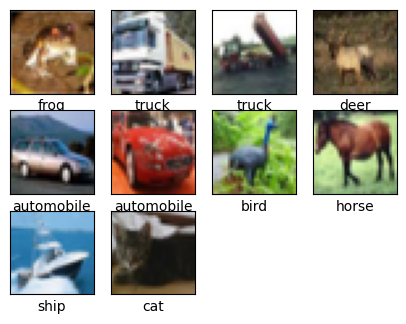

In [18]:
import matplotlib.pyplot as plt
def mostrar():
  plt.figure(figsize=(5,5))
  for i in range(10):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imagenes_entrenamiento[i], cmap=plt.cm.binary)
    plt.xlabel(nombres_clases[etiquetas_entrenamiento[i][0]])
  plt.show()
mostrar()

Una capa de entrada para imagenes de 32x32 pixels con 3 dimensiones de colores.
Dos capas convolucionales para extraer caracteristicas, con 32 filtros de 3x3. Quitando relleno que no se ajusta.
Dos capas de agrupamiento con filtros de 2x2 para achicar la anterior.

Una capa complemtamente conectada (densa) con 64 neuronas.
Una capa de salida con 10 neuronas para clasificar.

In [19]:
capa = keras.layers
modelo = keras.models.Sequential()
modelo.add(capa.Conv2D(64, (3,3), padding="same", activation='relu', input_shape=(32,32,3)))
modelo.add(capa.BatchNormalization())
modelo.add(capa.Conv2D(64, (3,3), padding="same", activation='relu')) # capa extra
modelo.add(capa.BatchNormalization()) 
modelo.add(capa.MaxPool2D(2,2))
modelo.add(capa.Dropout(0.3)) # ajusto de 0.25 a 0.3

modelo.add(capa.Conv2D(128, (3,3), padding="same", activation='relu')) # aumento el número de filtros de 64 a 128
modelo.add(capa.BatchNormalization())
modelo.add(capa.Conv2D(128, (3,3), padding="same", activation='relu')) # capa extra
modelo.add(capa.BatchNormalization())
modelo.add(capa.MaxPool2D(2,2))
modelo.add(capa.Dropout(0.3)) # ajusto de 0.25 a 0.3

modelo.add(capa.Flatten())
modelo.add(capa.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) # aumento el número de neuronas de 64 a 128
modelo.add(capa.Dropout(0.5))
modelo.add(capa.Dense(10, activation='softmax')) # agrego softmax para clasificacion multiclase 

modelo.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_5 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                      

Configuracion del modelo

In [20]:
modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Entrenamiento (creación del modelo)

Loss se busca el número mas bajo. Accuracy el más alto

In [ ]:
# Callbacks para optimizar el entrenamiento
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

# 1. Crear una pipeline de datos eficiente con tf.data
# Capas para hacer Data Augmentation en la GPU (mucho más rápido)
data_augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Crear los datasets
batch_size = 256 # Un batch size más grande es mejor para la GPU
autotune = tf.data.AUTOTUNE # Permite a TensorFlow optimizar la pipeline automáticamente

# Dataset de entrenamiento
train_dataset = tf.data.Dataset.from_tensor_slices((imagenes_entrenamiento, etiquetas_entrenamiento))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
train_dataset = train_dataset.map(lambda x, y: (data_augmentation_layers(x, training=True), y), num_parallel_calls=autotune)
train_dataset = train_dataset.prefetch(buffer_size=autotune) # ¡Esta es la clave!

# Dataset de validación
val_dataset = tf.data.Dataset.from_tensor_slices((imagenes_verificacion, etiquetas_verificacion))
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=autotune)


# 2. Definición de Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('mejor_modelo.keras', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# 3. Entrenamiento del modelo usando la nueva pipeline de datos
history = modelo.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Epoch 1/100
196/196 [==============================] - 14s 62ms/step - loss: 2.3030 - accuracy: 0.2705 - val_loss: 3.1599 - val_accuracy: 0.1668 - lr: 0.0010
Epoch 2/100
196/196 [==============================] - 12s 60ms/step - loss: 1.9151 - accuracy: 0.3628 - val_loss: 2.6215 - val_accuracy: 0.2094 - lr: 0.0010
Epoch 3/100
196/196 [==============================] - 12s 59ms/step - loss: 1.7209 - accuracy: 0.4238 - val_loss: 1.3960 - val_accuracy: 0.5719 - lr: 0.0010
Epoch 4/100
196/196 [==============================] - 12s 58ms/step - loss: 1.5949 - accuracy: 0.4638 - val_loss: 1.2831 - val_accuracy: 0.5849 - lr: 0.0010
Epoch 5/100
196/196 [==============================] - 12s 56ms/step - loss: 1.5077 - accuracy: 0.4961 - val_loss: 1.4381 - val_accuracy: 0.5383 - lr: 0.0010
Epoch 6/100
196/196 [==============================] - 12s 60ms/step - loss: 1.4274 - accuracy: 0.5281 - val_loss: 1.2399 - val_accuracy: 0.6140 - lr: 0.0010
Epoch 7/100
196/196 [==============================]

In [ ]:
modelo.evaluate(imagenes_verificacion, etiquetas_verificacion, batch_size=256)

In [ ]:
#predict()

**CONTINUAR DESDE ACA**